## Exploratory data analysis

Read Dataset

In [1]:
import matplotlib.pyplot as plt 
import pyspark.sql.functions as F
import pandas as pd
import json

from pyspark.sql import SparkSession

from src.eda import utils
from src.reader import read

# Opening JSON file with the configuration
with open('./constants/config.json') as f: config = json.load(f)

# Make spark session object
spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("zillow_house")
    .getOrCreate()
)

# Setup constants
for key, value in config["spark"].items():
    spark.conf.set(key, value)

# Read data
df = read(spark , config["data"])

Plot missing data per column

23/12/17 18:33:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


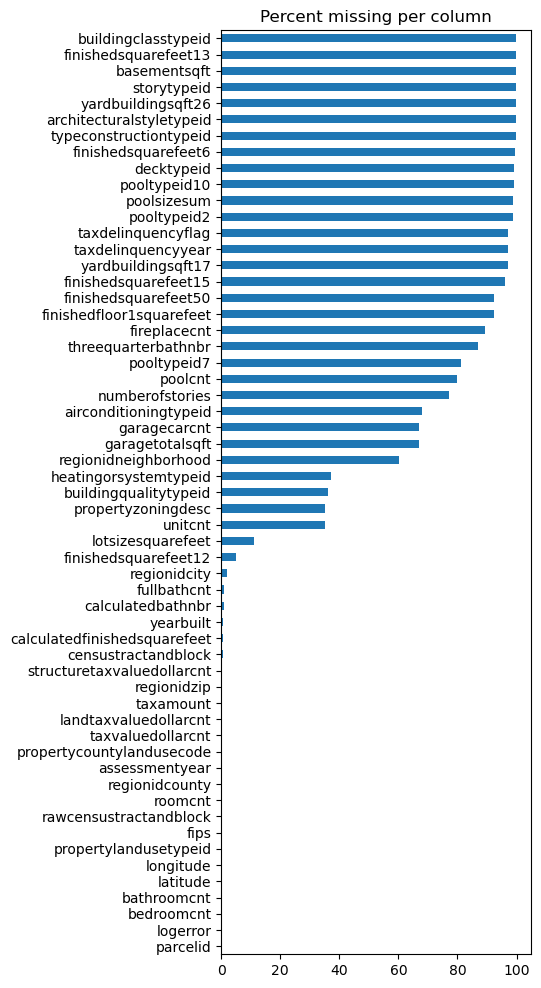

In [56]:
# Make a summary of the dataframe
summary = (
    df
    .describe()
    .toPandas()
    .T
)

# Set column names
summary.columns = summary.iloc[0]
summary.drop(summary.index[0], inplace = True)

# Compute + plot missing values
numRows       = df.count()
summary       = summary.apply(pd.to_numeric, errors = 'coerce')
missingValues = (1 - summary['count'] / numRows) * 100
missingValues.columns = ["missing_percent"]

missingValues.sort_values(inplace = True)
missingValues.plot.barh(figsize = (4, 12), title = "Percent missing per column");

A lot of columns with missing data. 

### Categorical Variables

Check the distribution of values for the categorical variables:

In [ ]:
uniqueDist = lambda col: (
    df
    .groupby(col)
    .agg(
        ( F.round( F.count("*") / numRows * 100, scale = 3) ).alias("count")
    )
    .orderBy("count", ascending = False)
)

catCols = [col for col, dtype in df.dtypes if dtype in ["boolean", "string"]]
for col in catCols: uniqueDist(col).show()

### Continuous variables

#### Room, bedroom and bathroom counts

All variables are ordinal, therefore we can simply use spearman's rho correlation coefficient.

In [ ]:
cols  = ["roomcnt", "bathroomcnt", "bedroomcnt", "fullbathcnt"]
df_   = df.select(cols).dropna(how = 'any')
corr  = utils.correlation(df_, method = "spearman")

print(str(corr))

23/11/11 11:25:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


DenseMatrix([[ 1.        ,  0.02092963,  0.15837977, -0.03980567],
             [ 0.02092963,  1.        ,  0.56581493,  0.96747934],
             [ 0.15837977,  0.56581493,  1.        ,  0.56331821],
             [-0.03980567,  0.96747934,  0.56331821,  1.        ]])


There is high correlation between bathroomcnt and fullbathcnt. Arbitrarily, fullbathcnt will be removed.

In [ ]:
# Columns to summarize
numericCols = [col for col, dtype in df.dtypes if dtype not in ["boolean", "string"]]
cols        = [c for c in numericCols if c not in ["latitude", "longitude", "logerror"]]

# Make and show summary
sumdf = utils.summaryContinuous(df.select(cols))
sumdf = sumdf.T.sort_values('count')

# Convert nan count to percentage
sumdf['count'] = (sumdf['count'] / numRows) * 100

sumdf

summary,count,min,lower_extreme,25%,50%,75%,upper_extreme,max,mean,stddev,skewness
finishedsquarefeet13,0.044673,1056.00,1345.710327,1344.00,1440.00,1440.00,1438.289673,1584.0,1395.706667,116.539145,-1.140218
basementsqft,0.055394,38.00,279.172546,280.00,588.00,819.00,819.827454,3560.0,695.376344,583.952144,0.551636
yardbuildingsqft26,0.098280,12.00,86.294778,88.00,160.00,320.00,321.705222,1366.0,271.260606,293.611447,1.136815
finishedsquarefeet6,0.480678,257.00,1054.922900,1056.00,1886.00,3240.00,3241.077100,7224.0,2197.294919,1300.554048,0.718067
poolsizesum,1.094777,24.00,419.452980,420.00,500.00,600.00,600.547020,1750.0,518.930903,155.732980,0.364680
yardbuildingsqft17,3.001406,11.00,173.893573,175.00,252.00,375.00,376.106427,3191.0,307.919032,227.430960,0.737618
finishedsquarefeet15,3.925832,560.00,1632.921998,1634.00,2099.00,2845.00,2846.078002,35640.0,2368.333485,1124.302411,0.718668
finishedfloor1squarefeet,7.679524,44.00,944.288707,945.00,1252.00,1614.00,1614.711293,7625.0,1356.491895,661.068564,0.474195
finishedsquarefeet50,7.679524,44.00,944.255139,945.00,1252.00,1619.00,1619.744861,12467.0,1367.647018,698.669027,0.496574
garagetotalsqft,33.032140,0.00,1.469512,0.00,434.00,488.00,486.530488,7339.0,347.603909,264.565618,-0.979675


### Multivariate analysis

#### Living Area Columns

Check linear correlations among all variables:

In [ ]:
cols = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12']
df_  = df.select(cols).dropna(how = 'any')
corr = utils.correlation(df_, method = "pearson")
print(str(corr))

23/11/11 20:30:30 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


DenseMatrix([[1., 1.],
             [1., 1.]])


The field *finishedsquarefeet12* is exactly the same as *calculatedfinishedsquarefeet*. We can drop one. Arbitrarily, we drop the former, as it has a higher number of missing values.

#### Tax-related columns

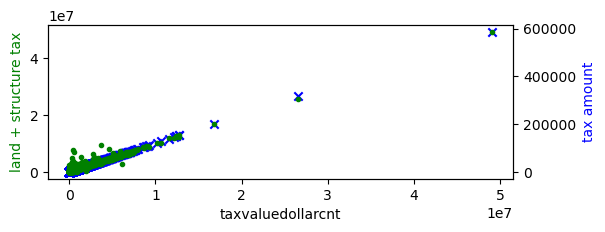

In [ ]:
taxCols = [
    "taxamount", 
    "landtaxvaluedollarcnt", 
    "structuretaxvaluedollarcnt", 
    "taxvaluedollarcnt"
    ]

taxdf = (
    df
    .select(taxCols)
    .sample(0.2)
    .withColumn(
        "land_add_structure", 
        F.col("landtaxvaluedollarcnt") + F.col("structuretaxvaluedollarcnt")
    )
    .toPandas()
)

fig, ax1 = plt.subplots(figsize = (6, 2))

ax2 = ax1.twinx()
ax1.scatter(taxdf["taxvaluedollarcnt"], taxdf["land_add_structure"], c = 'b', marker = 'x')
ax2.scatter(taxdf["taxvaluedollarcnt"], taxdf["taxamount"],          c = 'g', marker = '.')
ax1.set_ylabel('land + structure tax', color='g')
ax2.set_ylabel('tax amount', color='b')
ax1.set_xlabel('taxvaluedollarcnt')

plt.show()

So, the field *taxvaluedollarcnt* is the sum of the fields *landtaxvaluedollarcnt* and *structuretaxvaluedollarcnt*, so we can remove the latter two, as well as the *taxamount* field, due to its high correlation with the *taxvaluedollarcnt* field.

#### Garage-related columns

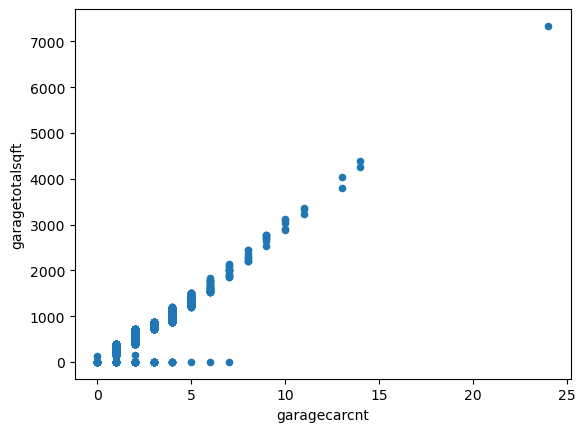

In [5]:
garageCols = ["garagecarcnt", "garagetotalsqft"]
garagedf   = df.select(garageCols).na.drop().toPandas()
garagedf.plot.scatter(y = "garagetotalsqft", x = "garagecarcnt");

These two fields are strictly correlated. It appears that some properties have zero *garagetotalsqft* but a high number of *garagecarcnt*. This means that there are properties with a garage, but its area has not been measured. 

We will process as follows:

Properties with zero *garagetotalsqft* and non-zero *garagecarcnt* will get a new *garagetotalsqft* values, as the mean of the non-zero *garagetotalsqft* with a given standar deviation for the same *garagecarcnt*.

#### Pool related columns

These columns include: hashottuborspa, poolcnt, poolsizesum, pooltypeid10, pooltypeid2, pooltypeid7.

In [ ]:
(
    df
    .select(["hashottuborspa", "pooltypeid10", "pooltypeid2"])
    .withColumn(
        "pooltype_spa", 
        (F.col("pooltypeid10") == 1) | (F.col("pooltypeid2") == 1)
        )
    .crosstab(
    col1 = "hashottuborspa",
    col2 = "pooltype_spa"
    )
).show()

+---------------------------+------+----+
|hashottuborspa_pooltype_spa|  null|true|
+---------------------------+------+----+
|                       true|     0|3904|
|                       null|163984|   0|
+---------------------------+------+----+



In [ ]:
(
    df
    .select(["pooltypeid2", "pooltypeid7", "poolcnt"])
    .withColumn("haspool_cnt", F.col("poolcnt") >= 1)
    .withColumn("haspool_id", (F.col("pooltypeid2") == 1) | (F.col("pooltypeid7") == 1))
    .crosstab(col1 = "haspool_cnt", col2 = "haspool_id")
).show()

+----------------------+------+-----+
|haspool_cnt_haspool_id|  null| true|
+----------------------+------+-----+
|                  true|    21|34054|
|                  null|133813|    0|
+----------------------+------+-----+



The information on the fields *pooltypeid10* and *pooltypeid2* is the same as in the fields *hashottuborspa* and *poolcnt*. The former indicates if there is a spa or a hot tub, and the later indicates if there is a pool (it's basically a binary variable, as it's only Null or has a value of 1 - there are no houses with more than one pools in the dataset). 

For sure we can remove *pooltypeid10* and *pooltypeid2*.

In [ ]:
(
    df
    .select(["poolsizesum", "poolcnt"])
    .withColumn("sizesum", F.col("poolsizesum").isNull())
    .withColumn("counts", F.col("poolcnt").isNull())
    .crosstab(col1 = "sizesum", col2 = "counts")
).show()

+--------------+-----+------+
|sizesum_counts|false|  true|
+--------------+-----+------+
|         false| 1838|     0|
|          true|32237|133813|
+--------------+-----+------+



However, there is a discrepancy caused by the missing values: Approximately 32000 properties have a null *poolsizesum* and non-null *poolcnt*. This implies that there is a pool in these properties, but the pool size is not measured. Using the same approach as the garage columns will not work , as we cannot reliably estimate poolsize based on the number of pools (there is either one or none pools). This means that we will have to keep both columns. After filling nulls with zeros, we will have basically "convert" the *poolcnt* column to an indicator variable on whether the *poolsizesum* variable has indeed been measured if non-zero.

### EDA Summary 

#### Drop 
finishedsquarefeet13, finishedsquarefeet6, finishedsquarefeet15, finishedfloor1squarefeet, finishedsquarefeet50, finishedsquarefeet12, yardbuildingsqft26, basementsqft, landtaxvaluedollarcnt, structuretaxvaluedollarcnt, taxamount, pooltypeid10, pooltypeid2, buildingclasstypeid, fullbathcnt, architecturalstyletypeid, storytypeid, taxdelinquencyyear, typeconstructiontypeid, regionidzip

#### Preparation

* Properties with zero *garagetotalsqft* and non-zero *garagecarcnt* will get a new *garagetotalsqft* values, as the mean of the non-zero *garagetotalsqft* for the same *garagecarcnt*.
* Null indicator variable: buildingqualitytypeid

#### Missing data

Fill null with:
* Zeros: poolsizesum, yardbuildingsqft17, garagetotalsqft, lotsizesquarefeet, numberofstories, poolcnt, pooltypeid7, fips, decktypeid, fireplacecnt, heatingorsystemtypeid, propertylandusetypeid, buildingqualitytypeid, regionidcounty, regionidneighborhood, regionidcity, propertyzoningdesc, threequarterbathnbr, unitcnt, airconditioningtypeid, garagecarcnt
* Mean: yearbuilt, calculatedfinishedsquarefeet, taxvaluedollarcnt, bedroomcnt, bathroomcnt, calculatedbathnbr, roomcnt
* 'N': taxdelinquencyflag
* 2015: assessmentyear

#### Transformations

* Log transform: calculatedfinishedsquarefeet, yardbuildingsqft17, taxvaluedollarcnt, lotsizesquarefeet
* If not 0, set to 1: decktypeid, fireplacecnt
* heatingorsystemtypeid: All values except 2, 7, 0 (previously null) set to 3.
* propertylandusetypeid: Set all values except for: 261, 266, 246, 269 to 0 (as "other" category)
* propertyzoningdesc: Bin everything except the following categories (strings): LAR1, LAR3, LARS, LBR1N, LARD1.5, LAR2, SCUR2, LARD2 to a single (other) category.
* propertycountylandusecode: Bin everything except the following categories (strings): 0100, 122, 010C, 0101, 34, 1111, 1, 010E, 010D, 0200, to a single (other) category.
* taxdelinquencyflag: Convert to binary ('N' = 0, 'Y' = 1)
* airconditioningtypeid: Only the categories 0 (previously Null), 1, and 13 will be retained. The rest will be grouped to another 'all else' category.
* One-hot encoding: airconditioningtypeid, fips, heatingorsystemtypeid, propertycountylandusecode, propertylandusetypeid, propertyzoningdesc, regionidcounty
* Feature hashing: censustractandblock, rawcensustractandblock, regionidneighborhood, regionidcity